# PHT Eclipsing Binary Catalog

- data covered: sectors 1 - 39 (2 years of Southern hemisphere and 1 year of Northern hemisphere)

In [25]:
from importlib import reload

from IPython.display import display

import pandas as pd
from pandas.io.clipboard import clipboard_set

import catalog
import catalog_stats
from catalog_stats import CAT_COLS_COMMON

## Tagging accuracy and Catalog coverage

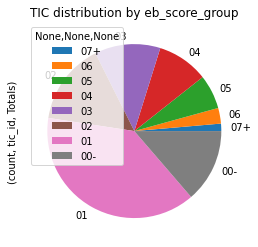

In [2]:
reload(catalog)
reload(catalog_stats)

df_catalog = catalog.load_pht_eb_candidate_catalog_from_file()

report, styler = catalog_stats.pivot_by_eb_score_group(df_catalog, also_return_styler=True)
display(styler)


ax = report[report.index != "Totals"].plot.pie(y=('count', 'tic_id', 'Totals'));
ax.set_title("TIC distribution by eb_score_group");

## Coverage of individual catalogs

In [20]:
report_simbad, styler_simbad = catalog_stats.pivot_by_eb_score_group(df_catalog, columns="SIMBAD_Is_EB", also_return_styler=True)
# display(report_simbad[report_simbad.index == "Totals"])
display(styler_simbad)

report_vsx, styler_vsx = catalog_stats.pivot_by_eb_score_group(df_catalog, columns="VSX_Is_EB", also_return_styler=True)
# display(report_vsx[report_vsx.index == "Totals"])
display(styler_vsx)

### Compare raw number of EB votes vs adjusted eb_score 
- can we just use raw `num_votes_eb`, rather than adjusted `eb_score`, to gauge the likelihood of TIC being an eclipsing binary?

In [51]:
report_by_score, styler_by_score = catalog_stats.pivot_by_eb_score_group(df_catalog, row="num_votes_eb_group", also_return_styler=True)
display(styler_by_score)

In [61]:
df_catalog.columns

Index(['tic_id', 'best_subject_id', 'best_subject_sector', 'is_eb_catalog',
       'eb_score_group', 'eb_score', 'num_votes_eb', 'num_votes_transit',
       'num_users', 'num_comments', 'updated_at', 'best_subject_img_id',
       'num_subjects', 'sectors', 'subject_ids', 'SIMBAD_MAIN_ID',
       'SIMBAD_Is_EB', 'SIMBAD_OTYPES', 'SIMBAD_V__vartyp', 'SIMBAD_angDist',
       'SIMBAD_Match_Score', 'VSX_OID', 'VSX_n_OID', 'VSX_V', 'VSX_Name',
       'VSX_Is_EB', 'VSX_Type', 'VSX_Period', 'VSX_angDist',
       'VSX_Match_Score'],
      dtype='object')

In [26]:
df = df_catalog
df = (
    df
    [df["is_eb_catalog"] == "F"]
    .groupby("eb_score_group")
    .head(2)
    .sort_values(["eb_score_group"], ascending=[False])
    )
# clipboard_set(df[CAT_COLS_COMMON].to_markdown())
# df[CAT_COLS_COMMON].to_clipboard()
df[CAT_COLS_COMMON].style.hide(axis='index')

tic_id,best_subject_id,is_eb_catalog,eb_score,SIMBAD_MAIN_ID,SIMBAD_OTYPES,SIMBAD_Is_EB,VSX_Name,VSX_Type,VSX_Is_EB,VSX_Period
143669444,32026607,F,11,HD 64881,*|IR,-,HD 64881,ACV|ELL,F,1.103900
281581467,60853074,F,7,TYC 8911-718-1,PM*|*|IR,-,ASASSN-V J074356.39-602347.2,ROT:,F,nan
4200337,56365918,F,6,nan,nan,-,CSS_J052244.8-010231,BY,F,8.164117
77209028,30249806,F,6,CD-38 1652,Ro*|V*|*|IR|X,F,ASAS J043559-3841.6,ROT,F,0.568900
17342647,48229829,F,5,HD 144359,*|IR|UV,-,HD 144359,HB,F,4.382000
43273020,48223594,F,5,AG+41 1420,PM*|BY*|SB*|V*|*|IR|X,F,V1221 Her,BY,F,1.813700
22120766,41413067,F,4,CD-23 8836,Ro*|PM*|V*|*|IR|X,F,ASAS J095357-2408.8,ROT,F,1.668000
35044762,60849117,F,4,TYC 7702-75-1,*|IR,-,ASASSN-V J095059.01-425034.5,L,F,nan
8669966,48223652,F,3,* 32 Her,SB*|**|*|IR|UV,-,NSV 20695,ELL+DSCT,F,3.394306
10863087,52587377,F,3,RX J0143.7-0602,PM*|SB*|Er*|PM*|*|*|IR|X,F,nan,nan,-,nan
